In [3]:
# import requests
import torch
# import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [8]:
words = open('names.txt', 'r').read().splitlines()
words += open('nomes_br.csv', 'r').read().lower().splitlines()
words = list(dict.fromkeys(words))
print(len(words))
print(words[:10])
print(max(len(w) for w in words))

57750
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
15


In [21]:
chars = ['.'] + sorted(list(set(''.join(words))))
itos = dict(zip(range(len(chars)), chars))
stoi = dict(zip(chars, range(len(chars))))
vocab_size = len(chars)
print('chars', chars)
print('stoi', stoi)
print('itos', itos)
print('vocab_size', vocab_size)

chars ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
vocab_size 27


In [71]:
# build datasets
import random

block_size = 8 # how many letters do we take to predict the next

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [stoi['.']] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# Randomize the words order
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words)) # ponto de corte em 80%
n2 = int(0.9 * len(words)) # ponto de corte em 90%

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([348676, 8]) torch.Size([348676])
torch.Size([43738, 8]) torch.Size([43738])
torch.Size([43468, 8]) torch.Size([43468])


In [72]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '---->', itos[y.item()])

........ ----> j
.......j ----> a
......ja ----> v
.....jav ----> o
....javo ----> n
...javon ----> n
..javonn ----> .
........ ----> m
.......m ----> a
......ma ----> r
.....mar ----> i
....mari ----> e
...marie ----> .
........ ----> a
.......a ----> e
......ae ----> r
.....aer ----> i
....aeri ----> s
...aeris ----> .
........ ----> j


In [98]:
from typing import Any
import torch.nn as NN

torch.manual_seed(42);

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x: torch.Tensor):
        if self.training:
            dim = tuple(range(x.ndim - 1))
            xmean = x.mean(dim, keepdim=True)
            xvar = x.std(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        #
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embeddings_dim):
        self.weight = torch.randn((num_embeddings, embeddings_dim))
    
    def __call__(self, IX) -> torch.Tensor:
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n) -> None:
        self.n = n

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        self.out = x.view(B, T // self.n, C * self.n)

        if self.out.shape[1] == 1:
           self.out = self.out.squeeze(dim=1) 
           
        return self.out

    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers) -> None:
        self.layers = layers
        self.layers[-1].weight *= 0.1 # last layer make less confident
    
    def __call__(self, x) -> Any:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [116]:
n_emb = 24 # dim of embedding vectors
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_emb), 
    FlattenConsecutive(2), Linear(n_emb    * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# Params init
# with torch.no_grad():
#     layers[-1].weight *= 0.1 # las layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [117]:
# for layer in model.layers:
#     print(layer.__class__.__name__, ':', tuple(layer.out.shape))

torch.Size([128])

In [118]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch contruct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # foward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backwards
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

print(loss.item())

      0/ 200000: 3.2859
  10000/ 200000: 2.1383
  20000/ 200000: 2.1244
  30000/ 200000: 1.6982
  40000/ 200000: 2.4093
  50000/ 200000: 1.7878
  60000/ 200000: 2.0351
  70000/ 200000: 1.9841
  80000/ 200000: 2.3153
  90000/ 200000: 1.8358
 100000/ 200000: 1.7777
 110000/ 200000: 2.0216
 120000/ 200000: 1.5785
 130000/ 200000: 1.9771
 140000/ 200000: 1.9909
 150000/ 200000: 1.6908
 160000/ 200000: 2.1370
 170000/ 200000: 2.0206
 180000/ 200000: 2.0656
 190000/ 200000: 1.7901
1.8379871845245361


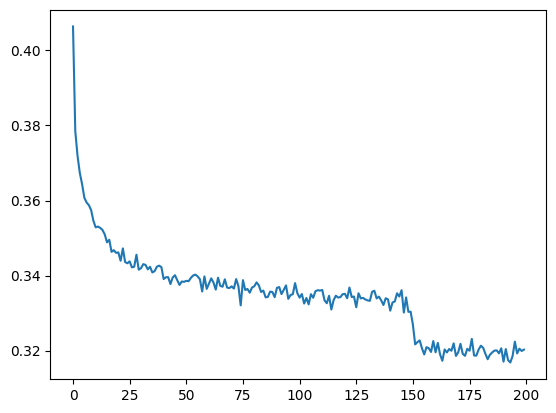

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [119]:
for layer in model.layers:
    layer.training = False

In [120]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8518491983413696
val 1.9539812803268433


In [121]:
# sample from the model
for _ in range(20):

    out = []
    context = [stoi['.']] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:]+[ix]
        if ix == 0:
            break
        out.append(ix)
    
    name = ''.join(itos[i] for i in out)
    
    found = name in words

    print(f'{name} - {found}')

rosilane - True
eciria - False
josiya - False
kenolane - False
domar - False
leonita - True
shriya - True
zoba - False
dovam - False
raje - False
kelita - True
nerci - True
janelly - True
swin - False
belland - False
willyss - False
zedverdo - False
francislene - True
lordene - False
siddara - False
